# トポロジカルデータ解析のためのツール
このノートでは、
- TDA(トポロジカルデータ解析)が実務家に提供するもの（次元削減、可視化、特徴量抽出など）
- 各手法が受け付ける入力の型（点群、画像、時系列）
- 色々なツールを、どう調整のために使うか
- 新たな研究のためのいくつかの種

を見ていきます。

このノートは鍛冶静雄によって書かれたもので、[ここ](https://github.com/shizuo-kaji/TutorialTopologicalDataAnalysis)でメンテナンスされています。

In [ ]:
## 必要なライブラリを持っていない場合は、このセルを実行してください（一度だけ）。
# 注意! 数分かかります。
## このノートをローカルで実行している場合は、numpy, scipy, scikit-learnのような標準的なライブラリをインストールしてください。
# パッケージマネージャの"conda"を利用することをお勧めします。例："conda install scikit-learn"

!pip install -q ripser umap-learn kmapper persim PersistenceImages
!pip install -q cripser
!pip install -q tomaster Boruta gudhi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.6 MB/s eta 0:00:00


In [ ]:
# 必要なライブラリの読み込み
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import glob,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
import persim
import gudhi
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt

### 後で使う関数の定義

# 指定された生成・消滅の特性をもつサイクルのヒートマップを計算する関数
# ヒートマップ画像は、PH(パーシステントホモロジー)によってどのような画像の特徴が捉えられるのかを明らかにしています。

from scipy.ndimage.filters import convolve
# 畳み込みのためのガウシアンカーネル
def gaussian(h,sigma):
    x = np.arange(-h[0],h[0],1)
    y = np.arange(-h[1],h[1],1)
    z = np.arange(-h[2],h[2],1)
    xx, yy,zz = np.meshgrid(x,y,z)
    return(np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2)).astype(np.float32))

def heat_map(img,pd,h=3,sigma=1,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True,location='birth'):
  if len(img.shape)==2:
    mx,my=img.shape
    mz = 1
    kernel = gaussian([h,h,1],sigma)
  else:
    mx,my,mz=img.shape
    kernel = gaussian([h,h,h],sigma)

  selected_cycle = np.zeros((mx,my,mz))
  ppd = pd[pd[:,0] == dimension]
  ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
  ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
  ppd = ppd[min_birth < ppd[:,1]]
  ppd = ppd[ppd[:,1] < max_birth]
  w = 1
  for c in ppd:
      if location=='birth':
        x,y,z=int(c[3]),int(c[4]),int(c[5])
      else:
        x,y,z=int(c[6]),int(c[7]),int(c[8])
      if life_weighted:
        w = c[2]-c[1]
      #selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += w
      selected_cycle[x,y,z] += w
  #print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))
  cycle_conv = convolve(selected_cycle,kernel)
  #print(np.min(cycle_conv),np.max(cycle_conv),np.sum(cycle_conv))
  return(np.squeeze(cycle_conv))

<ipython-input-2-c779257f9966>:13: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt
<ipython-input-2-c779257f9966>:20: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [ ]:
# # Google Colabを使用する場合、
# 左側の"ファイル"タブを使用することもできます。
# 代わりに、以下の方法でファイルをアップロードすることもできます。

#!ls
#from google.colab import files
#uploaded = files.upload()
#files.download('kepler-mapper-output.html')

# 様々なデータ型からの特徴量抽出

## 点群

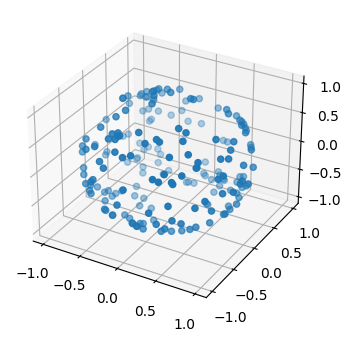

In [ ]:
## 2次元球面上のランダムなデータを生成
X = np.random.rand(200,3)-0.5  # [-0.5,0.5]^3 の範囲での、200個のランダムな点
X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True)) # 各行のベクトルが単位ベクトルになるように正規化
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

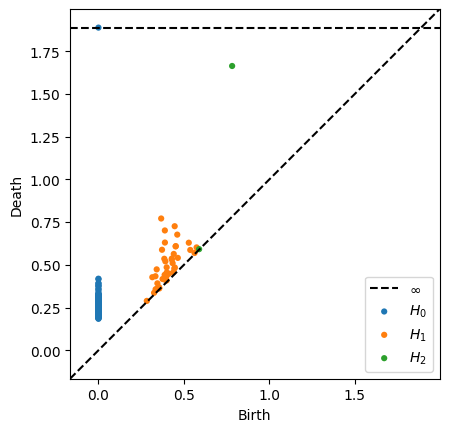

In [ ]:
## Vietoris-Rips(VR)複体のパーシステントホモロジー(PH)を計算し、パーシステンス図(PD)をプロットする
## VR-複体は膨大な単体を含んでいます。よって、点の最大数は1000のオーダーになります。
## You can compute an approximated PH by setting, e.g., "n_perm=100" (sub-sampling 100 points which are far apart).
## 例えば"n_perm=100"（離れた100点をサブサンプリングする）と設定することで、近似的なPHを計算することができます
diag = ripser(X,maxdim=2,n_perm=100)['dgms']
persim.plot_diagrams(diag)

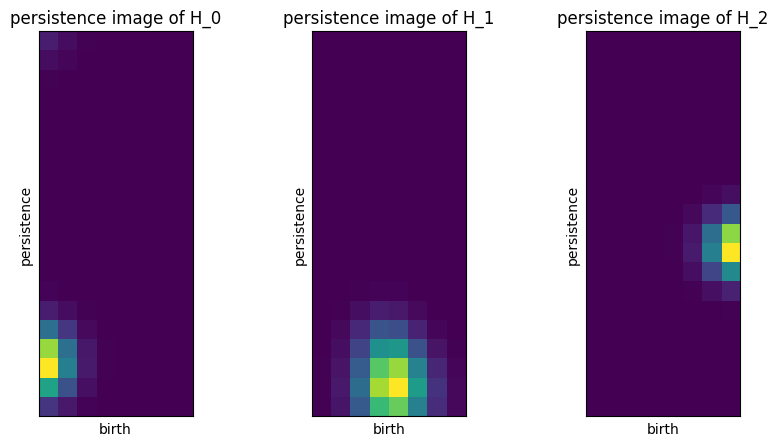

In [ ]:
# パーシステンスイメージのプロット
# 重み付けオプションについては、https://persim.scikit-tda.org/en/latest/reference/stubs/persim.PersistenceImager.htmlを見てください。

min_birth, max_death = 0,2
dclip = [np.clip(d,min_birth, max_death) for d in diag]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

plt.figure(figsize=(10,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    pimgr.plot_image(pimgs[i], ax)
    plt.title("persistence image of H_{}".format(i))

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

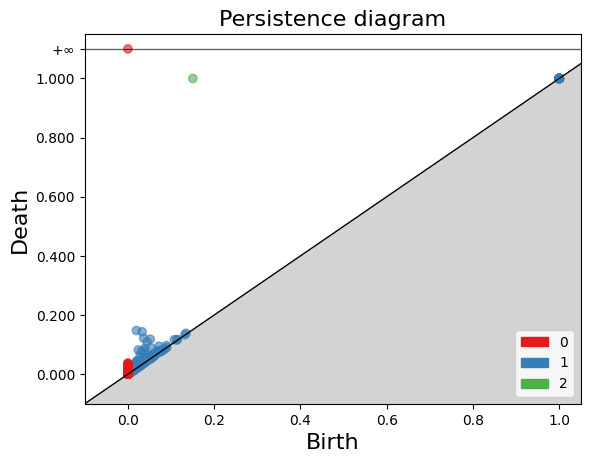

In [ ]:
## 点群から、異なる複体を構成することができます。
# どの複体を選ぶかは性能と結果に影響しますので、慎重に検討する必要があります。
# アルファ複体の例を見てみましょう。

simplex_tree = gudhi.AlphaComplex(points=X).create_simplex_tree()
diag = simplex_tree.persistence()

# 上記のVR複体の結果と比べて、H_1には明確な違いがあることが分かります。
gudhi.plot_persistence_diagram(diag, legend=True)

# !pip install cechmate  ## C++ compilers are required on the system
# import cechmate as cm
# alpha = cm.Alpha()
# filtration = alpha.build(X)
# dgmsalpha = alpha.diagrams(filtration)
# persim.plot_diagrams(dgmsalpha)

## パーシステント図の間の距離
- 分類/可視化の例

In [ ]:
# 球面と立方体からの標本点
def sample_sphere(n,radius=1):
    X = np.random.rand(n,3)-0.5
    X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True))
    X *= radius
    X += np.random.normal(scale=0.2,size=(len(X),3))
    X += np.random.uniform(-1,1,3)
    return(X)
def sample_cube(n,radius=1):
    X = 2*np.random.rand(n,3)-1
    X *= radius
    X += np.random.uniform(-1,1,3)
    return(X)

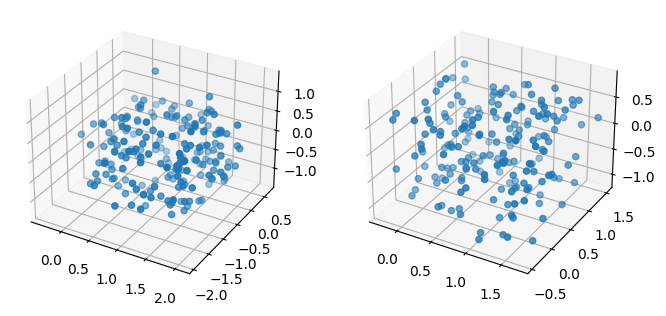

In [ ]:
# 球面と立方体から点群を生成し、PHにおけるペアごとのボトルネック距離を計算する

n=5   # 球面（立方体）の数。全部で2n個の点群ができます。
X=[sample_sphere(200) for i in range(n)]
Y=[0]*n
X.extend([sample_cube(200) for i in range(n)])
Y.extend([1]*n)

## 点群をプロットする：人間の目では、三次元の点群を見分けるのは容易ではありません。
# 球面
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[0][:, 0], X[0][:, 1], X[0][:, 2])
# 立方体
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[n][:, 0], X[n][:, 1], X[n][:, 2])

# PHと距離を計算
pd = []
for i in range(2*n):
    pd.append(ripser(X[i],maxdim=2,n_perm=100)['dgms'][2])

D = np.zeros((2*n,2*n))
for i in range(2*n-1):
    for j in range(i+1,2*n):
        D[i,j]=persim.bottleneck(pd[i], pd[j])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


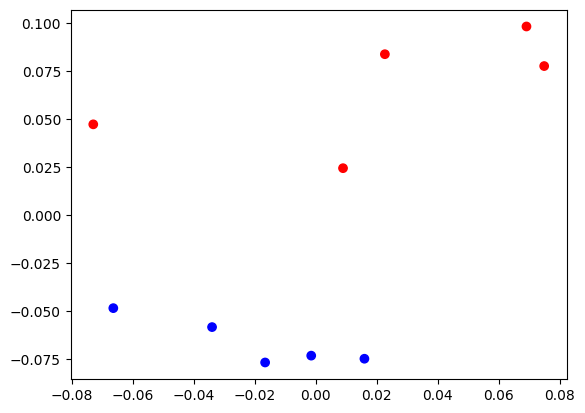

In [ ]:
## ボトルネック距離は球面と立方体を識別できます。
# 点群から距離行列が得られます。すなわち、2n個の点からなる有限距離空間が得られます。
# 可視化のために、多次元尺度構成法これは、有限距離空間をユークリッド空間に埋め込む手法です。
# 青い点は立方体を、赤い点は球面を表しています。
from sklearn.manifold import MDS
mds = MDS(n_components=2,dissimilarity='precomputed')
D = D+D.T
X_mds = mds.fit_transform(D)
col = ['r','b']
plt.scatter(X_mds[:,0],X_mds[:,1],c=[col[y] for y in Y])

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT
Distances
Bottleneck (GUDHI-hera) with L-infty metric: 6.499999999999999
Bottleneck (persim) with L-infty metric: 6.5
2-Wasserstein (GUDHI-hera) with L-infty metric: 12.504999999999999
2-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 17.684740597475553
99-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 9.192421749823405
99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance): 6.500023754826838


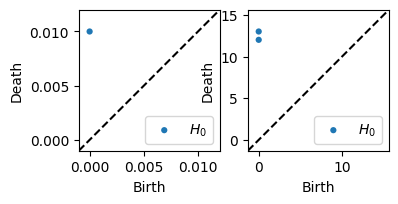

In [ ]:
## ボトルネック距離と、p-ワッサースタイン距離
# ワッサースタイン距離には、指数pと基底空間(R^2)の距離という2つのパラメータがあります。
import gudhi,gudhi.hera,gudhi.wasserstein,persim
X,Y =np.array([[0., 0.01]]), np.array([[0., 13.],[0.,12.]])
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(121)
persim.plot_diagrams(X, ax=ax)
ax = fig.add_subplot(122)
persim.plot_diagrams(Y, ax=ax)

print("Distances")
print("Bottleneck (GUDHI-hera) with L-infty metric:", gudhi.bottleneck_distance(X,Y))
print("Bottleneck (persim) with L-infty metric:", persim.bottleneck(X,Y))
#print(gudhi.wasserstein.wasserstein_distance(X, Y, order=1, internal_p=2)) ## requires pot
print("2-Wasserstein (GUDHI-hera) with L-infty metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=np.inf))
print("2-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance):", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=np.inf))

## ambient距離空間における点群

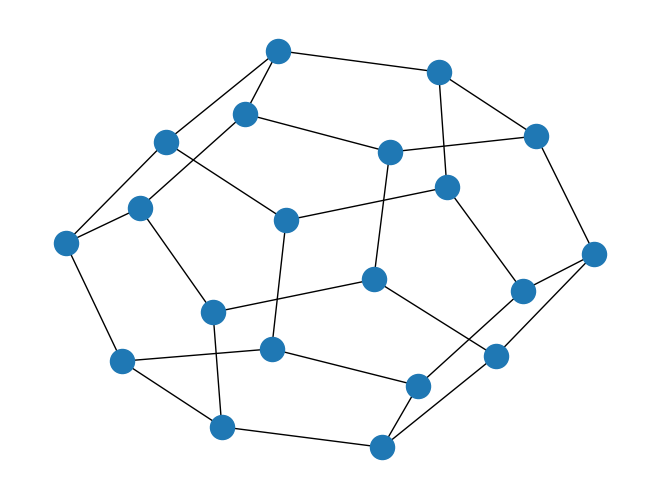

In [ ]:
## VR複体は、必ずしもユークリッド空間の点群からではなく、抽象的な距離行列から構成することもできます。
# グラフの距離の例を示します。
import networkx as nx
G=nx.dodecahedral_graph()
nx.draw(G)
D=np.array(nx.floyd_warshall_numpy(G)) # 距離行列

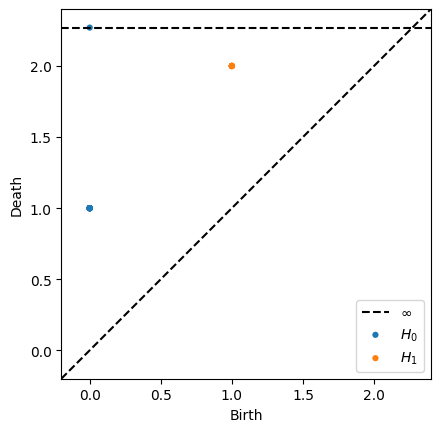

In [ ]:
# 距離行列のパーシステンスを計算する
diag = ripser(D,distance_matrix=True)['dgms']
persim.plot_diagrams(diag)

# (新しい研究の方向性)面白い問として：
# 点群（あるいは画像）において、まず、各点群に対してPDを計算し、そのPDの距離行列を計算することができます。
# 距離行列のPHは、"点群の集合"の特徴を定めます。
# 実践的な応用があるでしょうか?
# 例えば：それぞれのクラスのオブジェクトについて複数の測定結果があり、それぞれの測定結果からPHが得られます。
# この場合、"PDのPH"から、そのクラスのオブジェクトのついての集合的な特徴が分かります。

## PDの列におけるサイクルの軌道
(新しい研究の方向性)サイクルの経時的な追跡は、サイクルの代表元を見ることによって行われるべきです。しかし、手っ取り早い方法は、ワッサースタイン距離（最適輸送）で使われているマッチング手法を用いることです。点群の列から計算されたPDの列に対してこの方法を使うことで、このことを確かめてみます。

In [ ]:
# 8の字の例
def create_figure8(num_samples=200):
  t = np.linspace(0, 2*np.pi, num=num_samples)
  X = np.stack((np.sqrt(2)*np.cos(t) / (np.sin(t)**2+1), np.sqrt(2)*np.cos(t)*np.sin(t) / (np.sin(t)**2+1))).T
  X += 0.1*np.random.random(X.shape)
  return(X)

In [ ]:
# 縮尺を変えながら、8の字の列を生成する
# そして、それらのPDを計算する
Xs = []
diags = []
frames = 30
for fr in range(frames):
  a = frames/2
  X = create_figure8() * (a**2-(fr-a)**2)/(a**2)
  Xs.append(X)
  diags.append(ripser(Xs[fr],maxdim=1,n_perm=100)['dgms'])

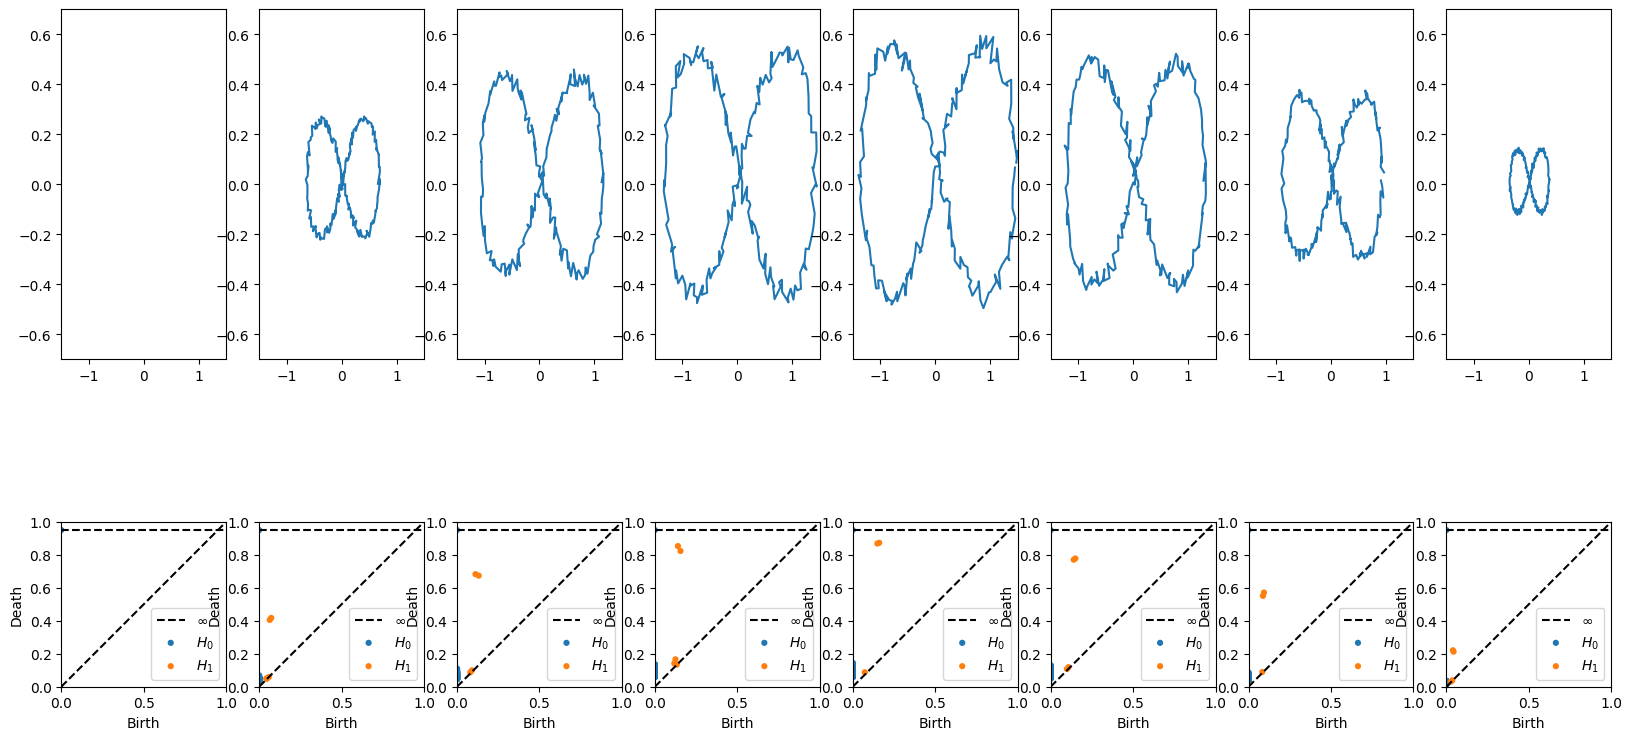

In [ ]:
# いくつかの例をプロットする
from mpl_toolkits.axes_grid1 import ImageGrid
num_disp=7
fig = plt.figure(figsize=(20, 10))
i=0
for x,dg in zip(Xs[::(len(Xs)//num_disp)],diags[::(len(Xs)//num_disp)]):
    un = len(Xs[::(len(Xs)//num_disp)])
    ax = fig.add_subplot(2,un,i+1)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-0.7,0.7)
    ax.plot(*x.T)
    persim.plot_diagrams(dg,xy_range=(0,1,0,1),ax=fig.add_subplot(2,un,i+1+un))
    i=i+1

In [ ]:
# 隣接するフレーム間のサイクルをマッチさせ、その軌跡をプロットする
import matplotlib.colors as colors
import matplotlib.cm as cm
def cycle_trajectory(diags,dim):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.xlim(0,0.3)
  plt.ylim(0,1)
  usercmap = plt.get_cmap('jet')
  cNorm  = colors.Normalize(vmin=0, vmax=len(diags))
  scalarMap = cm.ScalarMappable(norm=cNorm, cmap=usercmap)
  for i in range(len(diags)-1):
    D1 = diags[i][dim]
    D2 = diags[i+1][dim]
    d, M= persim.wasserstein(D1,D2,matching=True)
    for m in M:
      m0 = int(m[0]) # matched ids
      m1 = int(m[1])
      if -1<m0<len(D1) and -1<m1<len(D2):
        plt.plot( [D1[m0][0], D2[m1][0]],[D1[m0][1], D2[m1][1]],  'k-', lw=1)
#        plt.plot(*D1[m0],'ko')
        plt.plot(*D2[m1],'o',color = scalarMap.to_rgba(i))
  plt.colorbar(scalarMap, label="time")
  plt.xlabel("birth")
  plt.ylabel("life")
  plt.show()

<ipython-input-18-822b27e15edf>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarMap, label="time")


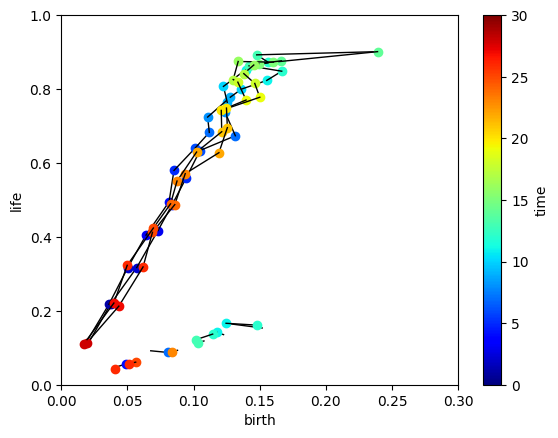

In [ ]:
## H_1の軌跡を可視化する
# 青：先のフレーム => 赤：後のフレーム
# 2つのサイクルが現れて成長し（長い時間にわたって存続している）、最終的に道を後戻りして消滅していることがわかります。
# 下にある、存続時間の短い点はノイズです。
cycle_trajectory(diags,dim=1)

## 画像と3次元画像

0 255 uint8


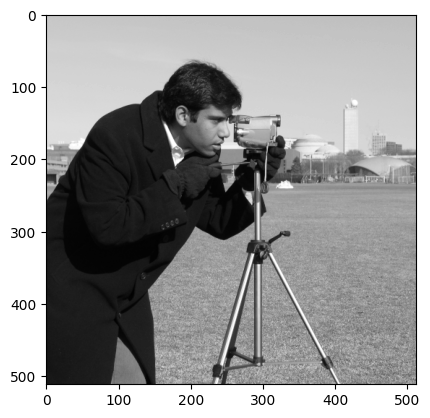

In [ ]:
## 写真のグレースケール変換
import skimage
from skimage import io
from PIL import Image
import cripser
# サンプル画像を読み込む
img = skimage.data.camera()
## 自分で画像をGoogle Colabにアップロードしたい場合は、
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# plot
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

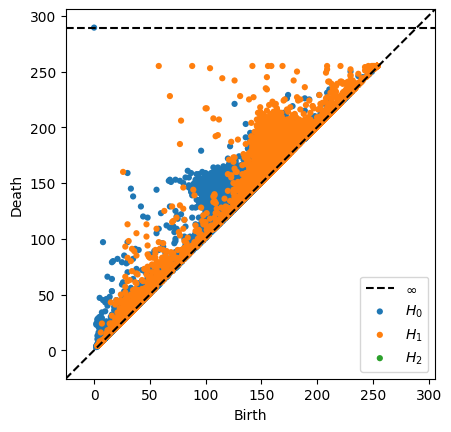

In [ ]:
## サブレベルフィルトレーションのパーシステンスを計算する

pd = cripser.computePH(img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

<ipython-input-22-b1e3e70dc658>:6: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


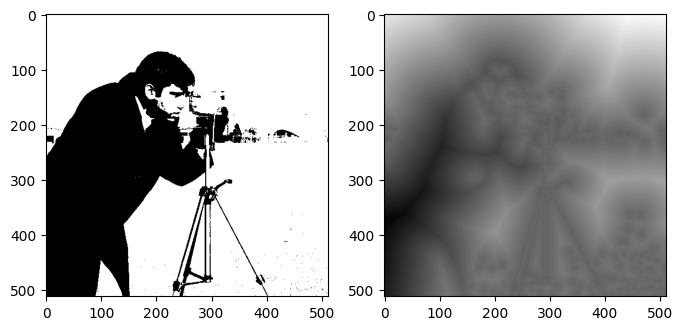

In [ ]:
## グレースケール画像に関しては、サブレベルフィルトレーションとは別の、パーシステンスの概念があります。
# 以下の関数は、入力した画像を2値化し、距離変換を適用します。
# サブレベルフィルトレーションは、データにおいてピクセルの値が重要な意味をもつとき（CTにおけるHUの値など）に適しています。
# 他方、距離変換は、データにおける幾何的な構造の尺度に興味があるときに適しています。

from scipy.ndimage.morphology import distance_transform_edt
from skimage.filters import threshold_otsu
bw_img = (img >= threshold_otsu(img))
dt_img = distance_transform_edt(bw_img)-distance_transform_edt(~bw_img)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

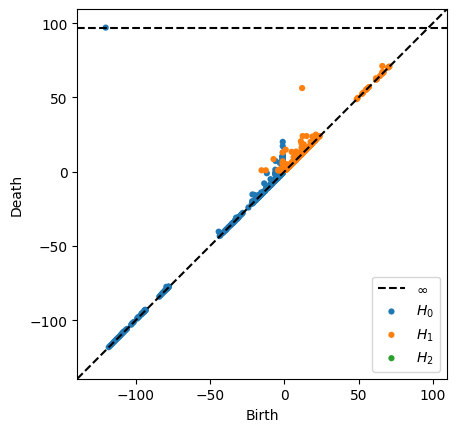

In [ ]:
# 距離変換のパーシステンスを計算する
pd = cripser.computePH(dt_img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

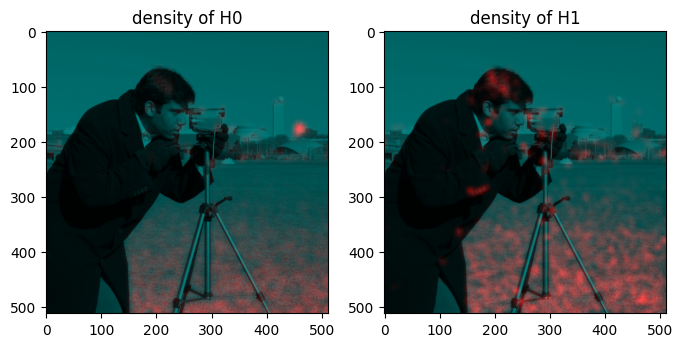

In [ ]:
## H_0とH_1のヒートマップをプロットする
pd = cripser.computePH(img,maxdim=1,location="birth")
fig = plt.figure(figsize=(8, 4))
for i in range(2):
  heat=heat_map(img,pd,h=10,sigma=5,min_birth=10,dimension=i)
  heat = (heat/np.max(heat) * 255).astype(np.uint8)
  ax = fig.add_subplot(1,2,i+1)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density of H{}".format(i))

(512, 512, 8) 0.0 1.0


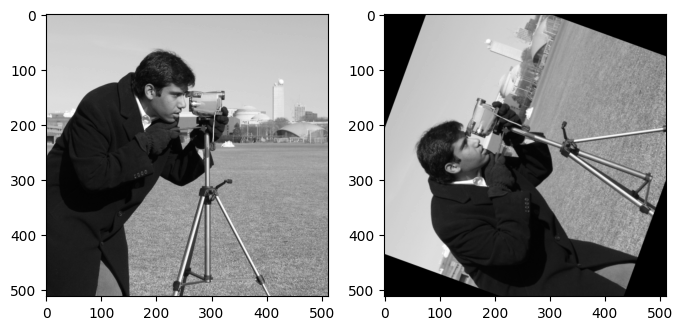

In [ ]:
## 3D volume
# ダミーのボリュームを、回転させたグレースケール画像を重ねることによって生成する
from skimage.transform import rotate
vol = np.dstack([rotate(img, 10*i) for i in range(8)])

## jpgファイルをディスクから読み込み、float64型の3次元配列にスタックする
#files = sorted([f for f in glob.glob("*.jpg")])
#vol = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')

# 最初と最後のスライスをプロットする
print(vol.shape, np.min(vol),np.max(vol))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(vol[:,:,0],cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(vol[:,:,-1], cmap='gray')

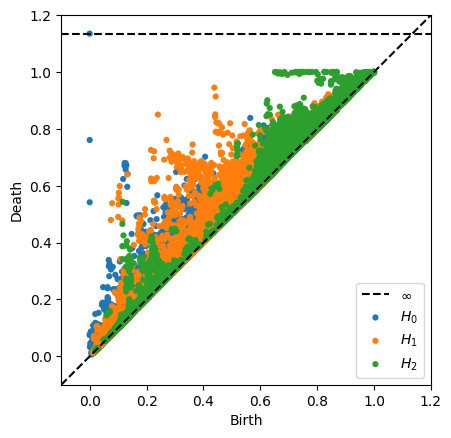

In [ ]:
## 3次元イメージについて、サブレブルフィルトレーションのパーシステンスを計算する
pd = cripser.computePH(vol,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

## 時系列データ
Time series is a 1D image so basically the techniques in the previous section apply straightforwardly. Here, we see examples with different tasks.

時系列は1次元のデータですから、基本的には、これまでのセクションで使った手法がそのまま使えます。ここでは、違った課題に対する例を見てみましょう。

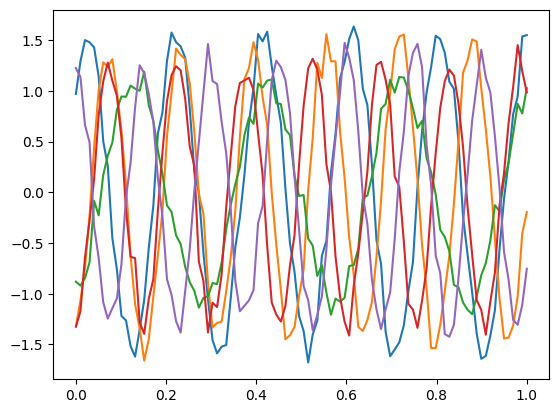

In [ ]:
# 人工的な例:
# 目標: ノイズのあるデータから、サインカーブの周期を予測する

n=200  # サンプルの数
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # 振幅
b=np.random.uniform(low=1.5,high=7,size=n) # 周期 <= 回帰の目標
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# ノイズのある、異なるサインカーブを生成する
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])

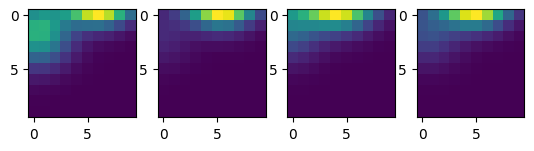

In [ ]:
## PHの計算とパーシステンス画像のベクトル化
import persim,cripser
import PersistenceImages.persistence_images as pimg

#pim=persim.PersImage(pixels=[10,10], spread=1) ## persimを使う場合
pim = pimg.PersistenceImager(birth_range=(0,5), pers_range=(0,5), pixel_size=0.5)
#print(pim)
pds, pims = [], []
for i in range(len(X)):
    pd = cripser.computePH(X[i])[:,1:3]    # PHを計算する
    pds.append(np.clip(pd,a_min=-2,a_max=2))  # 生成/消滅の最大値/最小値を制限
    pims.append(pim.transform(pds[i])) # パーシステンス画像でベクトル化
for i in range(4):   # パーシステンス画像をプロット
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i])
    #pim.show(pims[i], ax) ## persimを使う場合

MSE train : 0.166, test : 0.174
R2 train : 0.939, test : 0.908


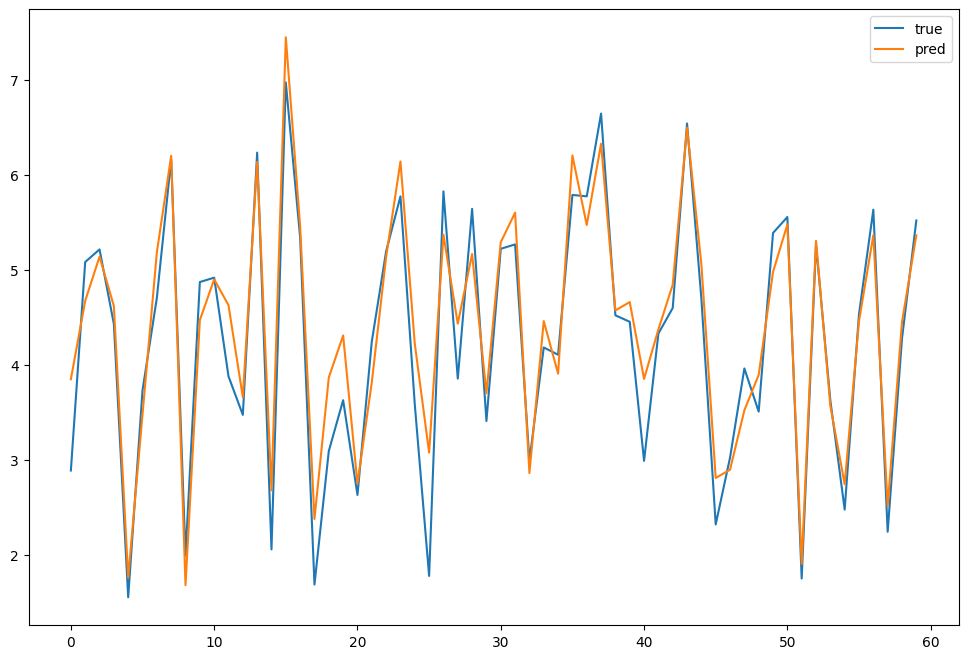

In [ ]:
# Lassoを利用した、周期についての回帰
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

# 訓練データとテストデータの分離
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# モデルの学習
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# 予測: まずまずの結果です
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

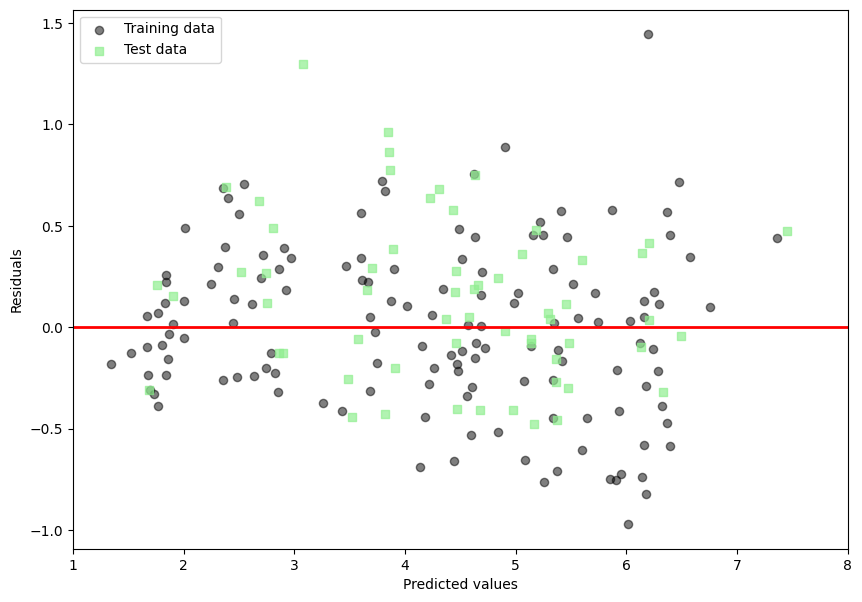

In [ ]:
# 残差のプロット
plt.figure(figsize = (10, 7))
plt.scatter(trainPred, trainPred - trainY, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(testPred, testPred - testY, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 1, xmax = 8, lw = 2, color = 'red')
plt.xlim([1, 8])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.434e+00, tolerance: 3.840e-02
  model = cd_fast.enet_coordinate_descent(


MSE train : 0.607, test : 10.103
R2 train : 0.779, test : -4.348


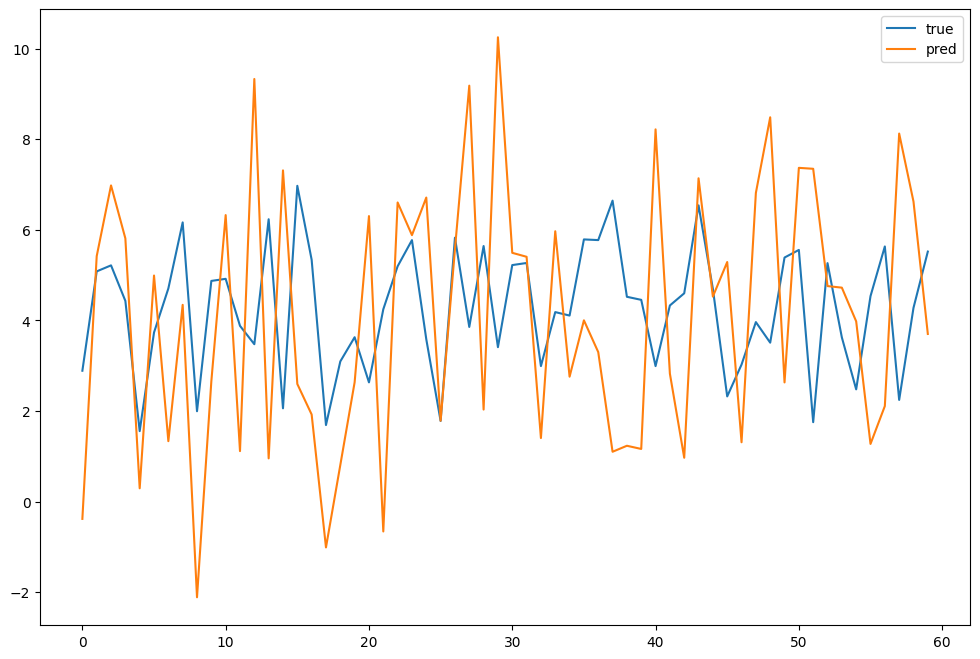

In [ ]:
## PHを使う代わりにオリジナルのデータを直接使う場合、
(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# モデルの学習
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# 予測: ずっと悪くなりました!
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()


MSE train : 0.634, test : 0.630
R2 train : 0.769, test : 0.667


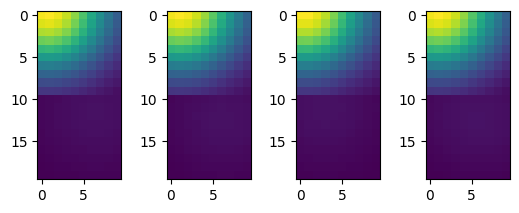

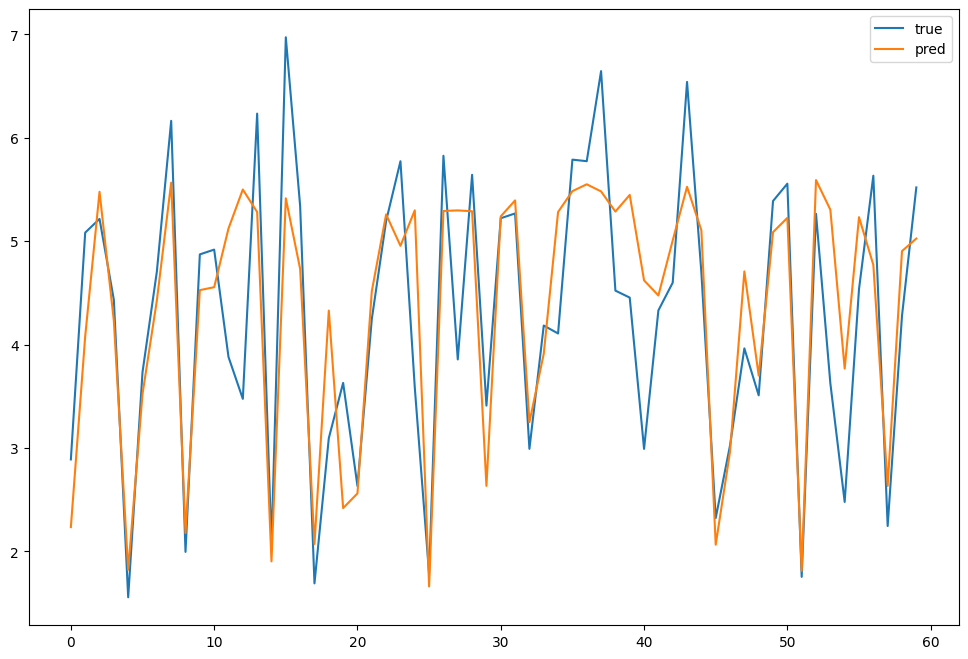

In [ ]:
# 実数上の関数として時系列のPHを直接計算する代わりに、
# まず時系列から幾何的な対象（近似的アトラクター）に変換し、それからPHによってトポロジカルな特徴を見るための手法とてTakensの埋め込みを使うことができます。

import gudhi.point_cloud.timedelay
embedder = gudhi.point_cloud.timedelay.TimeDelayEmbedding(dim=3, delay=2, skip=1)
X_takens = embedder.transform(X)

pim = pimg.PersistenceImager(birth_range=(0,2), pers_range=(0,2), pixel_size=0.2)
pds, pims = [], []
for i in range(len(X)):
    pd = ripser(X_takens[i])['dgms']    # compute PH
    pim0 = pim.transform(np.clip(pd[0],a_min=0,a_max=2)) #PH_0
    pim1 = pim.transform(np.clip(pd[1],a_min=0,a_max=2)) #PH_1
    pims.append(np.concatenate([pim0,pim1])) # combine PH_0 and PH_1 to make a feature vector
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i])
    #pim.show(pims[i], ax) ## for persim

## Lassoを用いた線形回帰
# 訓練データとテストデータの分離
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# モデルの学習
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# 予測: 結果は埋め込みを使わない場合よりも悪くなります。
# これはもっともなことです; 元の信号では、0次のベッチ数は周波数に相当するからです。
# ターケンスの埋め込みは、決定論的力学系からの信号を扱うときに有用です。
# 埋め込みによって、系のアトラクターが再構成されるからです。

trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.114, test : 0.990
R2 train : 0.958, test : 0.476


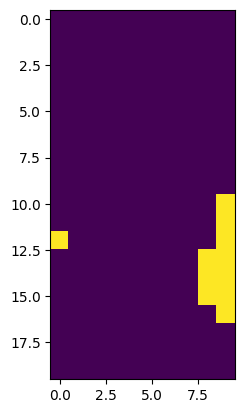

In [ ]:

## ランダムフォレストによる非線形特徴選択（少し時間がかかります）
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# Borutaによる特徴選択: 数分かかります
rf = RandomForestRegressor(n_jobs=-1,n_estimators=50,max_depth=15)
feat_selector = BorutaPy(rf, verbose=0)
feat_selector.fit(trainX, trainY)
#print(feat_selector.ranking_)

X_filtered = feat_selector.transform(trainX)
rf.fit(X_filtered, trainY)
trainPred = rf.predict(X_filtered)
testPred = rf.predict(feat_selector.transform(testX))
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# 選択した領域をパーシステント画像にプロットする
plt.imshow(feat_selector.support_.reshape(pims[0].shape))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 5s 285ms/step - loss: 20.1053 - val_loss: 16.5279
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 12.0534 - val_loss: 3.2492
Epoch 3/100
7/7 [==============================] - 1s 80ms/step - loss: 3.2364 - 

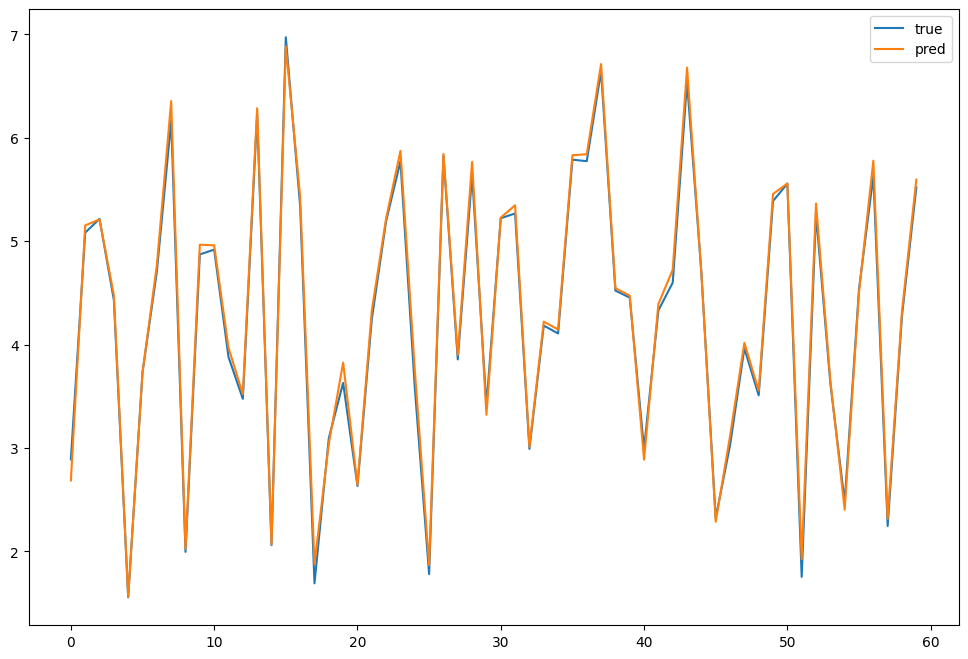

In [ ]:
## LSTM(一般的な回帰型ニューラルネットワーク)と比較してみましょう
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 訓練データとテストデータの分割
(trainX, testX, trainY, testY) = train_test_split(np.array(X).reshape(n,-1,1), b, test_size = 0.3, random_state = 0)

# LSTMモデルの定義
num_hidden_units = 128
model = Sequential()
model.add(LSTM(
    num_hidden_units,
    input_shape=(len(t), 1),
    return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
model.summary()

# 訓練
model.fit(trainX, trainY, batch_size=20, epochs=100,
    validation_split=0.1,   ## isn't it unfair?
    callbacks=[EarlyStopping(monitor='val_loss', mode='auto', patience=50)]
)

# 予測: LSTMの方かよい精度です
trainPred = model.predict(trainX)
testPred = model.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )
plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

## 次元削減
次元削減は、以下のような目的のために使える手法です。
- 可視化
- 回帰/分類の前処理として
- 異常値検出

(901, 64)


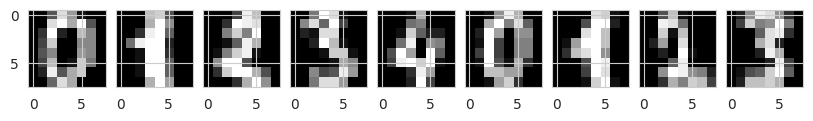

In [ ]:
# デモデータの読み込み: 手書きの数字
import sklearn
import sklearn.datasets
from scipy import stats
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
# seabornを使えば、matplotでの描画がきれいにできます
import seaborn as sns
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")

### 可視化

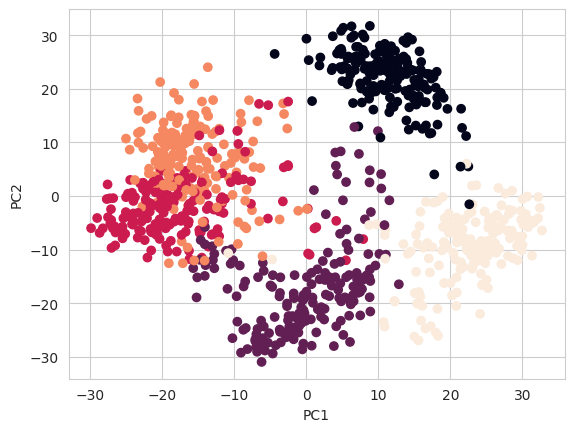

In [ ]:
## みんな大好きPCA: 確かに、異なるクラスに複数の重なりがみられます（点の色で示されています）が、それほど悪くありません。
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# 第1と第2の主成分をプロット
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

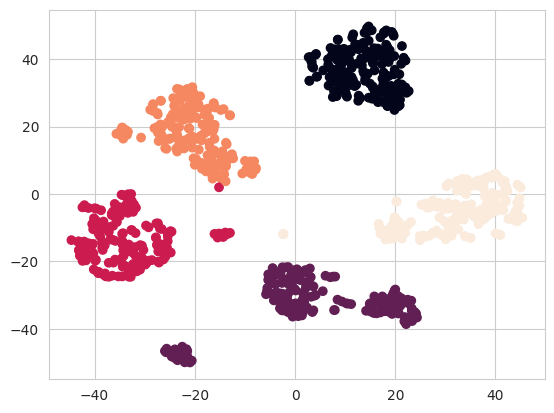

In [ ]:
# t-SNE: 最も一般的な手法の一つ。前処理としては最高ですが、成分の意味はあまり明確にはなりません。
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)


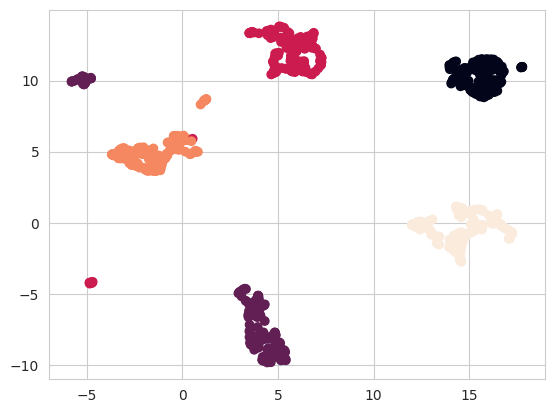

In [ ]:
# Universal Manifold Learning (umap): projects vectors while keeping the topology
# ユニバーサル多様体学習 (umap): トポロジーを保ちつつベクトルを射影する
import umap
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

Exception: ignored

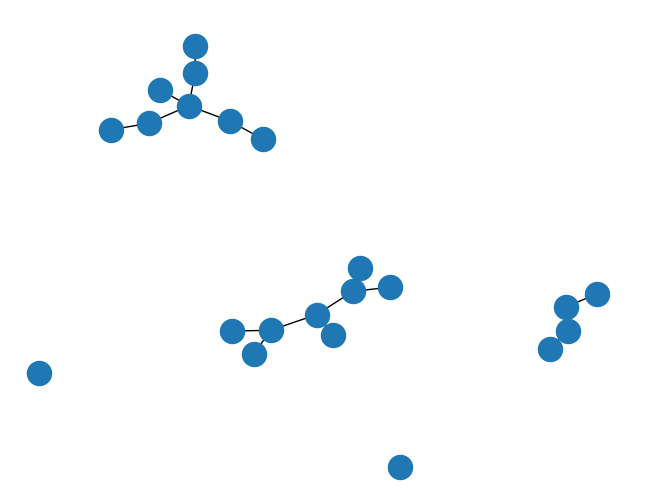

In [ ]:
## 豊富なトポロジーを明らかにするのに適していますが、調整が難しいです
# 可視化はGoogle Colabでは動きません。Jupyter-notebookを使ってください。

import kmapper, kmapper.jupyter
from sklearn.preprocessing import StandardScaler
import networkx as nx

km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # 標準化
f = km.project(X_std,projection="sum") # 1次元射影を選ばなければなりません
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
nx.draw(kmapper.adapter.to_nx(graph))
km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html") # 出力をダウンロードするには、このノートの冒頭を見てください。
print("Download kepler-mapper-output.html and open it with a browser to see the results.")

# 以下の豊富な可視化はGoogle Colabでは動作しません。
# "kepler-mapper-output.html"をダウンロードし、ブラウザでローカルに開いてください
#kmapper.jupyter.display(path_html="kepler-mapper-output.html")

### 分類

In [ ]:
## ランダムフォレストによる分類
# まず、ベクトルデータ（画像のピクセル値）を直接使う
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 訓練データとテストデータの分割
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# 分類結果
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



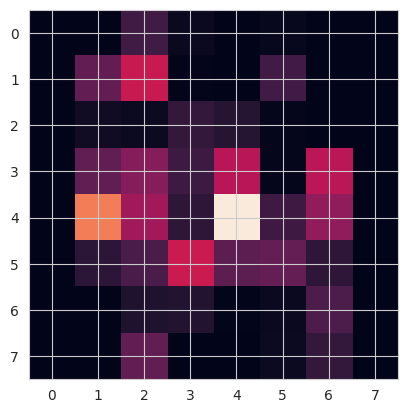

In [ ]:
## どの変数が決定に強く影響したのかを特定する
# この場合、どの数字を識別するために重要なピクセルはどれか
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [ ]:
## さあ、まず次元を下げて(64 -> 5)分類しましょう
# 精度が上がっているのが分かるはずです!
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [ ]:
## 比較のために、特徴量の抽出と分類のためにパーシステンス画像を使います
# この場合は、PHを見るためには不十分であることが分かります: まあまあの精度で分類できるのは0だけです
# TDAは従来の手法を代替するものではないということを理解するのは"非常に"重要です。
# 事実、大抵の場合、TDAは単独で使うとはるかに弱いです。したがって、TDAは補完的な分析手法として用いられるべきです。
pim = pimg.PersistenceImager(birth_range=(0,3), pers_range=(0,3), pixel_size=0.5)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i].reshape(8,8)
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # 距離変換のPHを計算する
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=0,a_max=3) # 生成/消滅の最大値/最小値を制限
    pds.append(pd)
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # パーシステンス画像によるベクトル化
    pims_h1.append(pim1.ravel()) # パーシステンス画像によるベクトル化

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[43  0  0  9  0]
 [ 0  0  0 61  0]
 [ 0  0  0 59  0]
 [ 1  0  0 51  0]
 [ 5  0  0 42  0]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        59
           3       0.23      0.98      0.37        52
           4       0.00      0.00      0.00        47

    accuracy                           0.35       271
   macro avg       0.22      0.36      0.24       271
weighted avg       0.21      0.35      0.23       271



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


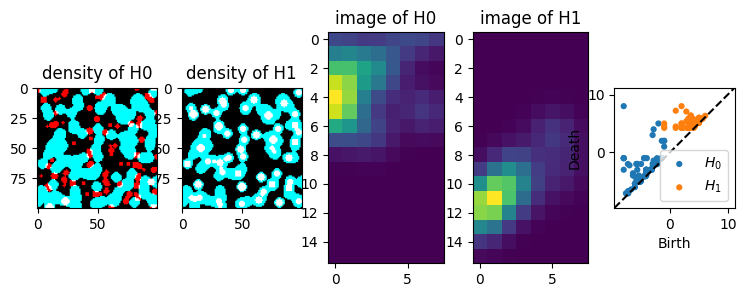

In [ ]:
# 分類のため、パーシステントホモロジー/パーシステンス画像から抽出された重要な特徴をプロットする
# x軸: 存続時間, y軸: 生成
k=0
img = X[k]*255
pd = pds[k]    # 距離変換のPHを計算する

fig = plt.figure(figsize=(9,3))
for d in range(2):
  heat=heat_map(img,pd,h=5,sigma=1,min_life=0,max_life=max_life,min_birth =-max_life,max_birth = max_life,dimension=d,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  ax = fig.add_subplot(1,5,1+d)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density of H{}".format(d))
  ax = fig.add_subplot(1,5,d+3)
  ax.imshow(pim.transform(pd[pd[:,0]==d,1:3]))
  ax.set_title("image of H{}".format(d))
persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = fig.add_subplot(1,5,5))

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Confusion matrix
 [[29  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



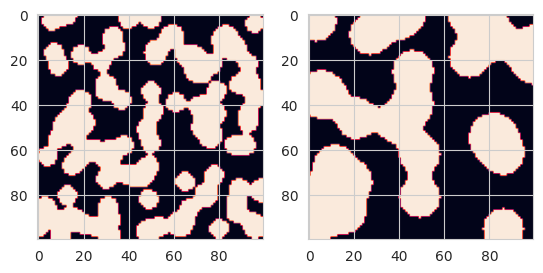

In [ ]:
## 特徴量抽出の方法としてPHが有効かどうかは、問題によります
## 人工的な実験をしてみましょう。この実験では、PHはうまく機能します。

## 大きさの異なるランダムな塊からなる分類問題を作成する
from skimage import data
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1).astype(np.float64) for i in range(n)]
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.2) for i in range(n)])
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])
plt.subplot(1,2,1)
plt.imshow(X[0])
plt.subplot(1,2,2)
plt.imshow(X[n])

### 分類
max_life = 8
pixel_size = 1

pim = pimg.PersistenceImager(birth_range=(-max_life,max_life), pers_range=(0,max_life), pixel_size=pixel_size)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i]
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)-distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # compute PH of distance transform # 距離変換のPHを計算する
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=-max_life,a_max=max_life) # clip min/max birth/death 生成/消滅の最大値/最小値を制限
    pds.append(pd)
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # パーシステンス画像によりベクトル化
    pims_h1.append(pim1.ravel()) # パーシステンス画像によりベクトル化

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Important feature. birth around: -2.666666666666667 lifetime around: 3.4285714285714284
255
0


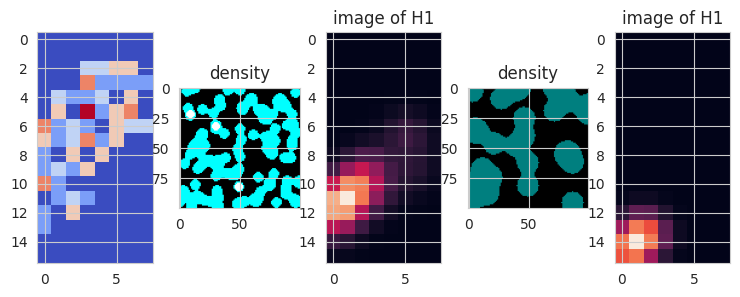

In [ ]:
## どの変数が決定に強く影響したか特定する
# この場合、H1のパーシステンス画像の領域である
# こういった可視化は、結果を説明したり、目の前の現象の背後にあるメカニズムを探求するのに役立ちます。

indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])

fig = plt.figure(figsize=(9,3))

ax = fig.add_subplot(1,5,1)
ax.imshow(clf.feature_importances_.reshape(pim1.shape),cmap='coolwarm')
most_important = np.unravel_index(indices[-1], shape=pim1.shape)
life,birth = np.meshgrid(np.linspace(0,max_life,pim1.shape[1]),np.linspace(-max_life,max_life,pim1.shape[0]))
b = birth[most_important]
l = life[most_important]
print("Important feature. birth around:", b,"lifetime around:", l)

# 画像上で最も寄与の大きい特徴の濃度をアノテーションする
# 例示のため、それぞれのクラスから1つずつ画像を選びます。
# アノテーションによって、分類機が2つのクラスをどう分類しているのかが分かります
idx = [0,n]
for i in range(len(idx)):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  h = 3*pixel_size
  heat=heat_map(img,pd,h=5,sigma=1,min_life=l-h,max_life=l+h,min_birth =b-h,max_birth = b+h,dimension=d,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  print(heat.max())
  ax = fig.add_subplot(1,5,2+i*2)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density")
  ax = fig.add_subplot(1,5,3+i*2)
  ax.imshow(pim.transform(pd[pd[:,0]==1,1:3]))
  ax.set_title("image of H{}".format(1))



## クラスタリング

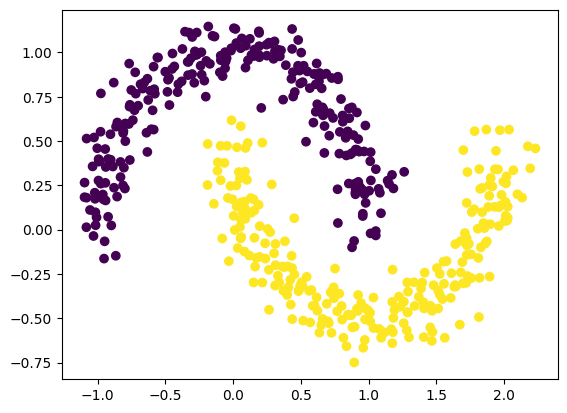

In [ ]:
## ToMATo (Topological Mode Analysis Tool)
# 面白く、かつあまり知られていないパーシステントホモロジーの応用としてクラスタリングがあります。
# 入力: 頂点に実数値が割り当てられたグラフ => 頂点のクラスタリング
import tomaster
import sklearn.datasets
X,_ = sklearn.datasets.make_moons(n_samples=500, noise=0.1)
clusters = tomaster.tomato(points = X, k=10, n_clusters=2)
plt.scatter(*X.T, c=clusters)
# こちらの結果と比べてみてください https://scikit-learn.org/stable/modules/clustering.html

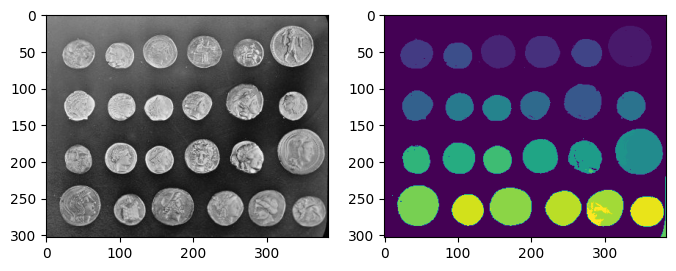

In [ ]:
## ToMaToの画像セグメンテーションへの応用
# 単なるデモンストレーションです: 通常のセグメンテーションタスクにはもっといい方法があります。
import skimage
img = skimage.data.coins()
clusters = tomaster.tomato_img(img, spatial_weight=1, k=10, n_clusters=30)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(clusters)
